In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt 
import pennylane as qml
import pennylane.numpy as np 
from main.operators import *
from main.VarQFT import *
from main.circuits import *

np.random.seed(1)

In this notebook we show how to employ our framework to obtain the ground state of a coupled system. We will consider two harmonic oscilator coupled by the Hooke's law. Let $X_j$ and $P_j$ the position and momentum operators of the $j$-th oscilator. The Hamiltonian is
$$ H =  P_1^2 + X_1^2 + P_2^2 + X_2^2 + ( X_1 - X_2)^2  . $$
We omit the factor $1/2$ for simplicity. To create the operator $X_1 - X_2$ we have to use the function ```distance```. We define a number of qubits for each system, and the total one will be the sum of them.

In [2]:
num_wires = 3
dev = qml.device( "lightning.qubit", 
                    wires=2*num_wires, shots=100)

In [3]:
wires1 = range(num_wires)
wires2 = range(num_wires,2*num_wires)

xrange = 5
X1, P1 = X_and_P_ops( range(num_wires), -xrange, xrange )    
X2, P2 = X_and_P_ops( range(num_wires,2*num_wires), -xrange, xrange )    

I1 = qml.Identity(wires1)
I2 = qml.Identity(wires2)

R = 0.25

H2 = [ 
        P1.pow(2),
        P2.pow(2),
        addition( X1, qml.s_prod(-R,I1), abs=True ).pow(-1).s_prod(-1),
        addition( X1, qml.s_prod(R,I1 ), abs=True ).pow(-1).s_prod(-1),
        addition( X2, qml.s_prod(-R,I2), abs=True ).pow(-1).s_prod(-1),
        addition( X2, qml.s_prod(R,I2), abs=True ).pow(-1).s_prod(-1),
        distance( X1, X2 ).pow(-1) 
        ]
H2 

[<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4, 5]>]

In [4]:
H2_matrix = tomatrix( H2 )

In [5]:
vals, vecs = np.linalg.eigh( H2_matrix )
vec = vecs[:,0]

In [6]:
vals

array([-3.46708790e+00, -3.33897986e+00, -2.84565788e+00, -2.76637036e+00,
       -2.54089476e+00, -2.36438685e+00, -2.03667484e+00, -1.85973995e+00,
       -1.44472059e+00, -1.35324587e+00, -1.22812404e+00, -1.08334410e+00,
       -9.80022875e-01, -9.31606844e-01, -6.34289785e-01, -4.11433775e-01,
       -3.64865634e-01, -2.75837310e-01, -2.71255506e-01, -2.32088998e-01,
        1.78044401e-01,  1.97365892e-01,  4.74507851e-01,  5.85432361e-01,
        6.45525167e-01,  7.99422500e-01,  9.81088256e-01,  1.05948638e+00,
        1.10656225e+00,  1.22727296e+00,  1.31096884e+00,  1.34766727e+00,
        1.54122418e+00,  1.73977114e+00,  1.91927050e+00,  1.93582882e+00,
        2.20957668e+00,  2.29649779e+00,  2.30709347e+00,  2.61004915e+00,
        2.62036544e+00,  2.71230053e+00,  2.94065473e+00,  2.97963401e+00,
        3.23655035e+00,  3.65850322e+00,  3.75176088e+00,  3.84210356e+00,
        3.94151601e+00,  4.32057534e+00,  4.39405034e+00,  4.54427756e+00,
        4.96814901e+00,  

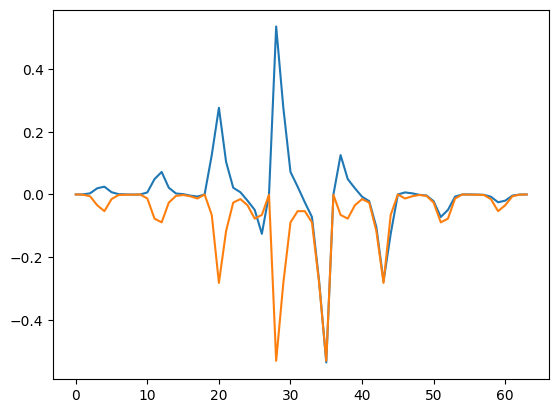

In [7]:
plt.plot( np.real(vecs[:,0]) )
plt.plot( -np.real(vecs[:,1]) )

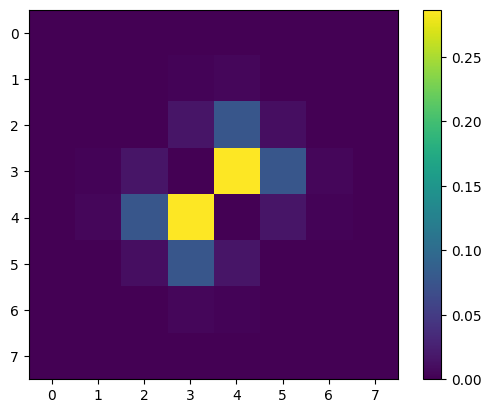

In [8]:
vec_reshape = vec.reshape( 2**num_wires, 2**num_wires )
plt.imshow( np.abs(vec_reshape)**2 )
plt.colorbar()

Obtaining the groud state by ```numpy``` for comparisons.

In [9]:
num_layers = 1
circuit_def = ZGR_ansatz( 2*num_wires - 1, num_layers )
num_params = circuit_def.num_params
params     = 0.001 * np.random.randn(num_params)
var_state  = circuit_def.construct_circuit

circuit_def_sym = symmetric_ansatz(circuit_def, antisymmetric=False)
var_state_sym  = circuit_def_sym.construct_circuit


In [10]:
varqft = VarFourier( H2, 
                    dev, 
                    var_state_sym )

In [11]:
Params, Energies = varqft.run( params , max_iterations=1000, learning_rate=0.1 )

c:\Users\lucia\miniconda3\envs\pennylane\Lib\site-packages\pennylane\_qubit_device.py:551: UserWarning: Requested measurement MyMP with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


Step:    201, Energy:    -2.867243


In [12]:
-3.025295--2.957058

-0.06823699999999988

In [13]:
-3.46708790e+00 - -3.33897986e+00

-0.1281080400000003

In [14]:
# np.save( 'data_asym', np.array([vals,vecs,Params,Energies], dtype=object))

In [15]:
dev = qml.device( "default.qubit", 
                    wires=2*num_wires )

ground_state = varqft.state( Params[-1], dev )

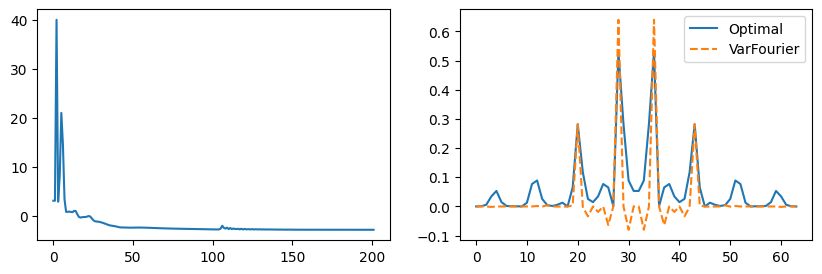

In [16]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( Energies )
# ax[0].hlines( val, 0, len(Energies), colors='tab:red', linestyles='--' )
# ax[1].plot( np.abs(vec)**2) 
plt.plot( np.real(vecs[:,1]) )
ax[1].plot( np.real(ground_state), '--' ) 
ax[1].legend(['Optimal','VarFourier'], loc='best') 
#ax[1].set_ylim([0.0,0.01])

In [17]:
np.abs( vecs.T.conj()@ground_state )

tensor([1.17958057e-14, 8.11159018e-01, 1.33458605e-01, 3.44700897e-01,
        9.02558416e-15, 1.36101837e-14, 1.98684257e-01, 3.28344234e-01,
        1.05069513e-14, 5.41422107e-15, 8.35054732e-14, 9.21508260e-02,
        9.46003328e-02, 2.32467365e-14, 7.09918795e-14, 1.20579904e-01,
        9.35405363e-02, 3.16196157e-15, 7.17251348e-04, 3.20059293e-15,
        7.02610497e-02, 1.43179364e-02, 9.34121007e-02, 2.12035252e-14,
        6.09525137e-15, 1.48766238e-02, 8.39500829e-15, 3.63035100e-03,
        1.90878532e-15, 5.39165332e-16, 6.33667571e-16, 4.94846145e-15,
        5.54136450e-16, 1.43585769e-02, 5.67441649e-03, 1.02116159e-14,
        1.86970599e-02, 1.03204379e-02, 1.36780371e-14, 3.23740123e-02,
        6.06278145e-04, 1.04283817e-14, 3.62072080e-02, 1.33213910e-03,
        2.42571317e-15, 6.96452071e-16, 4.15363273e-15, 1.38504693e-03,
        8.64898830e-16, 2.27322014e-03, 1.04278300e-02, 2.55042300e-15,
        1.41722846e-15, 7.33647440e-03, 5.73773381e-16, 6.700892

In [18]:
psi1 = np.abs(ground_state[0:8])**2
psi2 = np.abs(ground_state[8:15])**2

In [19]:
print(psi2)

[2.04251189e-12 3.43130219e-10 4.37125268e-10 1.92807544e-09
 2.44064116e-06 4.58234408e-07 1.71147341e-05]


[[-1.06684436e-09+0.j  2.16399681e-04+0.j  2.61965196e-08+0.j
  -1.72588525e-03+0.j  3.14474217e-06+0.j -1.25312059e-04+0.j
   1.24075655e-05+0.j  1.57738207e-05+0.j]
 [ 1.42916475e-06+0.j -1.85237744e-05+0.j -2.09075409e-05+0.j
  -4.39098558e-05+0.j  1.56225515e-03+0.j -6.76930135e-04+0.j
   4.13699578e-03+0.j  1.68600226e-05+0.j]
 [-2.64212692e-04+0.j -6.16279762e-04+0.j -3.34289943e-04+0.j
   3.34565549e-03+0.j  2.80724441e-01+0.j -1.66269891e-03+0.j
  -3.38469133e-02+0.j -6.51718963e-06+0.j]
 [-1.88085340e-02+0.j -8.11451173e-05+0.j -6.35296495e-02+0.j
  -8.91343418e-06+0.j  6.39710478e-01+0.j -4.69494651e-07+0.j
  -7.99457164e-02+0.j -6.30797884e-09+0.j]
 [-6.30797884e-09+0.j -7.99457164e-02+0.j -4.69494651e-07+0.j
   6.39710478e-01+0.j -8.91343418e-06+0.j -6.35296495e-02+0.j
  -8.11451173e-05+0.j -1.88085340e-02+0.j]
 [-6.51718963e-06+0.j -3.38469133e-02+0.j -1.66269891e-03+0.j
   2.80724441e-01+0.j  3.34565549e-03+0.j -3.34289943e-04+0.j
  -6.16279762e-04+0.j -2.64212692e-04+0.j

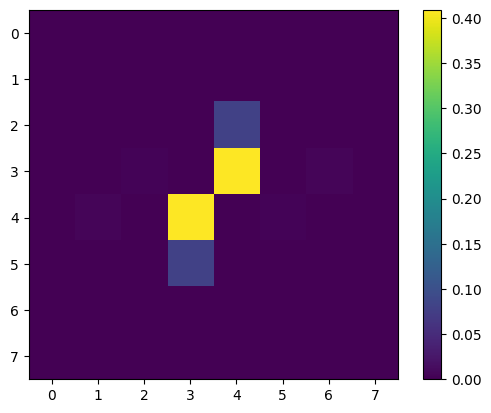

In [20]:
M = ground_state.reshape( 2**num_wires, 2**num_wires )
print(M)
plt.imshow( np.abs(M)**2 )
plt.colorbar()